In [1]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/nature_12K.zip"
extract_dir = "/content/nature"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [2]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [3]:
from torchvision import models
import torch.nn as nn

# Common base model function
def get_base_model():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # 10 classes
    return model

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import pytorch_lightning as pl

class INaturalistDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64, augment=False, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.augment = augment
        self.num_workers = num_workers

    def setup(self, stage=None):
        train_path = os.path.join(self.data_dir, "train")
        test_path = os.path.join(self.data_dir, "test")

        base_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

        augment_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor()
        ])

        full_train_dataset = datasets.ImageFolder(train_path, transform=augment_transform if self.augment else base_transform)
        test_dataset = datasets.ImageFolder(test_path, transform=base_transform)

        targets = np.array(full_train_dataset.targets)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_idx, val_idx in sss.split(np.zeros(len(targets)), targets):
            self.train_dataset = Subset(full_train_dataset, train_idx)
            self.val_dataset = Subset(full_train_dataset, val_idx)

        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [5]:
class FineTuner(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize lists to store metrics
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return {"test_loss": loss, "test_acc": acc}

    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=1e-4)

    def on_train_end(self):
        torch.save(self.model.state_dict(), "final_pt_model.pth")
        print("Model saved to final_model.pth")

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from pytorch_lightning import LightningModule, Trainer, Callback
from torch.nn import functional as F

# Model 1: Freeze all layers except the final classifier
def model1():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Model 2: Unfreeze only last two blocks (layer3, layer4)
def model2():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if name.startswith("layer3") or name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Model 3: Gradual unfreeze strategy
def model3():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if name.startswith("fc"):
            param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [8]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# Define datamodule
datamodule = INaturalistDataModule(data_dir="/content/nature/inaturalist_12K")

# Choose the model
selected_model = model2()  # model1(), model2(), or model3()

# Wrap in LightningModule
lit_model = FineTuner(selected_model)

# Gradual unfreeze callback for model3
callbacks = []

if selected_model == model3():
    class GradualUnfreezeCallback(Callback):
        def __init__(self, unfreeze_epoch=3):
            self.unfreeze_epoch = unfreeze_epoch

        def on_epoch_start(self, trainer, pl_module):
            if trainer.current_epoch == self.unfreeze_epoch:
                print(f"[GradualUnfreeze] Unfreezing layer4 at epoch {trainer.current_epoch}")
                for name, param in pl_module.model.named_parameters():
                    if name.startswith("layer4"):
                        param.requires_grad = True

    callbacks.append(GradualUnfreezeCallback(unfreeze_epoch=3))

# Trainer
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=10,
    callbacks=callbacks
)

# Train
trainer.fit(lit_model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
22.1 M    Trainable params
1.4 M     Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Model saved to final_model.pth


In [10]:
print("Final Training Accuracy:", trainer.callback_metrics.get("train_acc"))
print("Final Validation Accuracy:", trainer.callback_metrics.get("val_acc"))
print("Final Training Loss:", trainer.callback_metrics.get("train_loss"))
print("Final Validation Loss:", trainer.callback_metrics.get("val_loss"))

Final Training Accuracy: tensor(1.)
Final Validation Accuracy: tensor(0.7535)
Final Training Loss: tensor(0.0161)
Final Validation Loss: tensor(1.0874)


In [11]:
trainer.test(lit_model, dataloaders=datamodule.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7699999809265137     │
│         test_loss         │    0.9833141565322876     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9833141565322876, 'test_acc': 0.7699999809265137}]

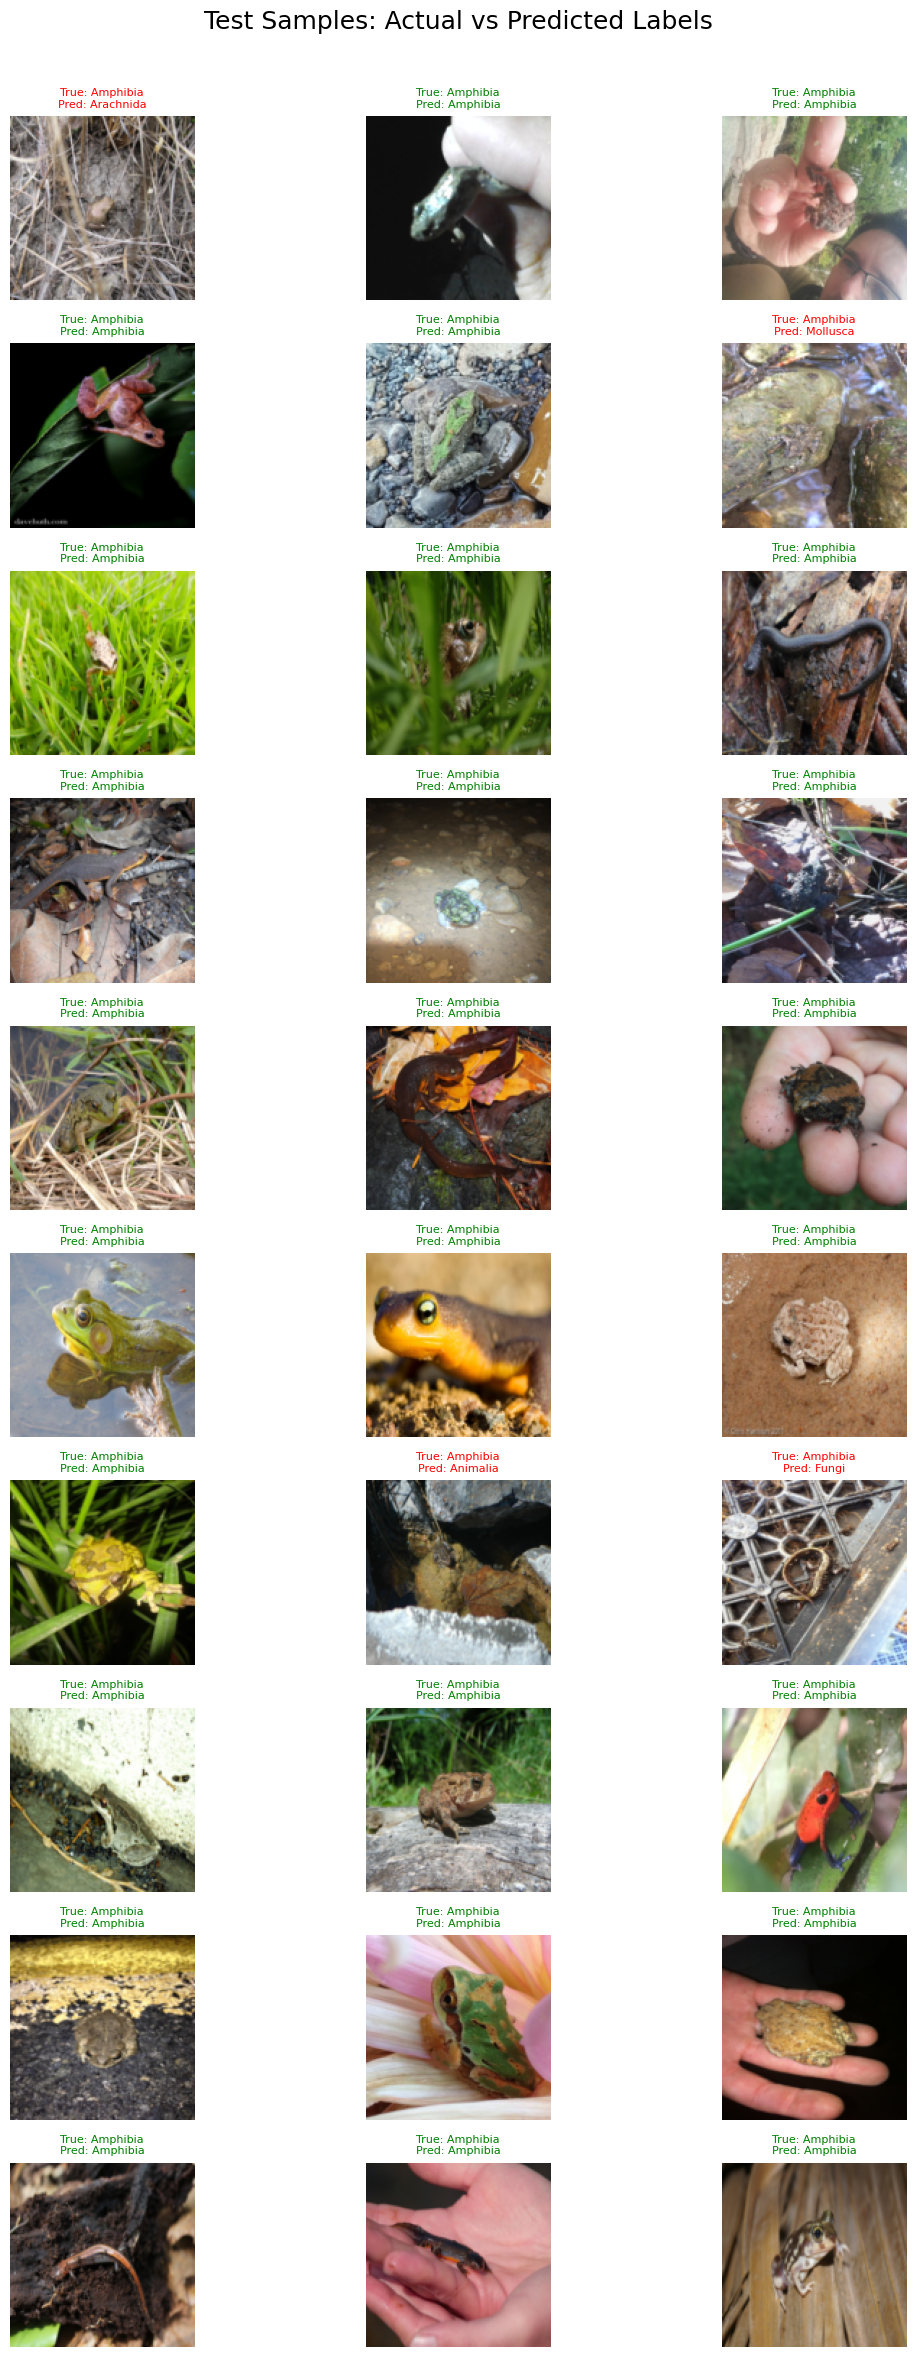

In [17]:
import matplotlib.pyplot as plt

test_loader = datamodule.test_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lit_model.to(device)
lit_model.eval()

class_names = datamodule.test_dataset.classes

samples = []
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = lit_model(imgs)
        preds = torch.argmax(outputs, dim=1)

    for img, label, pred in zip(imgs, labels, preds):
        if len(samples) >= 30:
            break
        samples.append((img.cpu(), label.cpu().item(), pred.cpu().item()))

    if len(samples) >= 30:
        break

# Plot 10×3 grid
fig, axes = plt.subplots(10, 3, figsize=(12, 24))
fig.suptitle("Test Samples: Actual vs Predicted Labels", fontsize=18)

for ax, (img, true_label, pred_label) in zip(axes.flat, samples):
    img = img.permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    title_color = "green" if true_label == pred_label else "red"
    ax.set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        fontsize=8,
        color=title_color
    )

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
